In [1]:
import networkx as nx
%pylab inline

Populating the interactive namespace from numpy and matplotlib


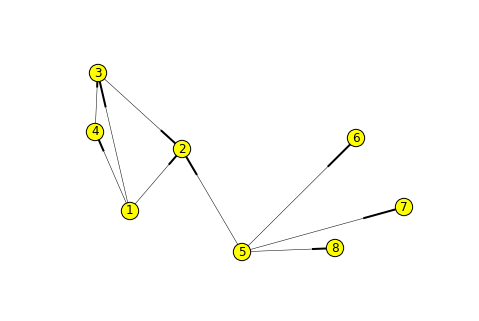

In [20]:
# Generate a simple directed graph
# think line represents an arrow
G = nx.DiGraph()
G.add_edges_from([(1, 2), (1, 3), (1, 4), (4, 3), (3, 2), (5, 2), (5, 6), (5, 7), (5, 8)])
nx.draw(G, with_labels = True, width=0.5, node_color='yellow')

In [16]:
# Initialize RDDs with sample data
outlinks_rdd = sc.parallelize([[1, [2, 3, 4]], [4, [3]], [3, [2]], [5, [6, 7, 8, 2]]])
print outlinks_rdd.collect()

inlinks_rdd = sc.parallelize([[4, [1]], [3, [1, 4]], [2, [1, 3, 5]], [6, [5]], [7, [5]], [8, [5]]])
print inlinks_rdd.collect()

# Initialize hub scores and auth scores
hub_score = sc.broadcast({1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1})
print hub_score.value

auth_score = sc.broadcast({1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1})
print auth_score.value

[[1, [2, 3, 4]], [4, [3]], [3, [2]], [5, [6, 7, 8, 2]]]
[[4, [1]], [3, [1, 4]], [2, [1, 3, 5]], [6, [5]], [7, [5]], [8, [5]]]
{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1}
{1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1}


In [17]:
# Define Python UDFs

def get_auth(x):
    page = x[0]
    outlinks = x[1]
    new_auth_score = 0
    # Get values from broadcast variable
    hub_lookup = hub_score.value
    
    for i in outlinks:
        try:
            new_auth_score += hub_lookup[i]
        except KeyError:
            pass
    
    return (page, outlinks, new_auth_score)

def get_hub(x):
    page = x[0]
    inlinks = x[1]
    new_hub_score = 0
    # Get values from broadcast variable
    auth_lookup = auth_score.value
      
    for i in inlinks:
        try:
            new_hub_score += auth_lookup[i]
        except KeyError:
            pass
    
    return (page, inlinks, new_hub_score)

In [14]:
outlinks_rdd = outlinks_rdd.map(lambda x: get_auth(x))

temp_auth_dict = auth_score.value
auth_score_collect = outlinks_rdd.map(lambda x: [x[0], x[2]]).collect()

for i in auth_score_collect:
    try:
        temp_auth_dict[i[0]] = i[1]
    except KeyError:
        pass

# Normalize
# Get values from broadcast variable (dictionary)
auth_get = auth_score.value.values()
norm = np.sqrt(sum([i ** 2 for i in auth_get]))

for k, v in temp_auth_dict.iteritems():
    temp_auth_dict[k] = round(v / norm, 2)
    
# Update the broadcast variable
# Unpersist from workers
auth_score.unpersist()
# Delete local Python object
del auth_score

auth_score = sc.broadcast(temp_auth_dict)
auth_score.value

{1: 0.41, 2: 0.35, 3: 0.14, 4: 0.14, 5: 0.55, 6: 0.35, 7: 0.35, 8: 0.35}

In [15]:
inlinks_rdd = inlinks_rdd.map(lambda x: get_hub(x))

temp_hub_dict = hub_score.value
hub_score_collect = inlinks_rdd.map(lambda x: [x[0], x[2]]).collect()

for i in hub_score_collect:
    try:
        temp_hub_dict[i[0]] = i[1]
    except KeyError:
        pass

# Normalize    
# Get values from broadcast variable (dictionary)
hub_get = hub_score.value.values()
norm = np.sqrt(sum([i ** 2 for i in hub_get]))

for k, v in temp_auth_dict.iteritems():
    temp_hub_dict[k] = round(v / norm, 2)
       
# Update broadcast variable
# Unpersist from workers
hub_score.unpersist()
# Delete local Python object
del hub_score

hub_score = sc.broadcast(temp_hub_dict)
hub_score.value

{1: 0.25, 2: 0.21, 3: 0.09, 4: 0.09, 5: 0.33, 6: 0.21, 7: 0.21, 8: 0.21}

In [8]:
# Unpersist and delete local object
auth_score.unpersist()
del auth_score
hub_score.unpersist()
del hub_score